In [99]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [69]:
m=10 # m assets
N=30 # N samples

$$\hat{J}_N(\varepsilon)=\begin{cases}\inf\limits_{x,\tau,\lambda,s_i,\gamma_{ik}}&\lambda\varepsilon+\frac{1}{N}\sum_{i=1}^Ns_i\\
s.t. &x\in \mathbb{X}\\
&b_k\tau+a_k\langle x,\hat{\xi}_i \rangle+\langle \gamma_{ik},d-C\hat{\xi}_i\rangle\le s_i \quad &\forall i\le N,\forall k\le K\\
&\Vert C^\top \gamma_{ik}-a_kx\Vert_*\le \lambda \quad &\forall i\le N,\forall k\le K\\
&\gamma_{ik}\ge 0 \quad &\forall i\le N,\forall k\le K
\end{cases}$$

In [70]:
rho=10 # weight of investor’s risk-aversion
alpha=0.2 # confidence level of the CVaR
K=2 # pointwise maximum of elementary measurable functions
Nd=1 # dimension of d where C*\xi\le d
a1=-1 
a2=-1-rho/alpha
b1=rho
b2=rho*(1-1/alpha)
a=[a1,a2]
b=[b1,b2]
x=cp.Variable((m,1),nonneg=True)
tau=cp.Variable()
lambda_=cp.Variable()
s=cp.Variable((N,1))
gamma=[ [cp.Variable((Nd,1)) for i in range(N)] for j in range(K)]
eps = cp.Parameter(nonneg=True)
eps.value = 0.1
xi_hat_para = cp.Parameter((m,N))
C= np.zeros((Nd,m))
d = np.zeros((Nd,1))

In [71]:
obj=cp.Minimize(lambda_*eps+1/N*cp.sum(s))
constraint = [cp.sum(x) == 1]
for k in range(K):
    for i in range(N):
        constraint += [b[k]*tau+a[k]*x.T @ xi_hat_para[:,i]+gamma[k][i].T @ (d-C @ xi_hat_para[:,i]) <= s[i]]
        constraint += [cp.norm(C.T @ gamma[k][i]-a[k]*x,'inf') <= lambda_]
        constraint += [gamma[k][i] >= 0]
# Use ``*`` for matrix-scalar and vector-scalar multiplication.
# Use ``@`` for matrix-matrix and matrix-vector multiplication.
# Use ``multiply`` for elementwise multiplication.

In [72]:
xi_hat_list = []
for i in range(N):
    psi=np.random.normal(loc=0,scale=np.sqrt(0.02))
    xi_temp_list = []
    for j in range(m):
        zeta=np.random.normal(loc=(j+1)*0.03,scale=np.sqrt((j+1)*0.025))
        xi=psi+zeta
        xi_temp_list += [xi]
    xi_hat_list += [np.array(xi_temp_list).reshape(-1,1)]

$$\psi\sim\mathcal{N}(0,2\%)$$
$$\zeta_i\sim\mathcal{N}(i\times 3\%,i\times 2.5\%)$$
$$\xi_i=\psi+\zeta_i,\quad i=1,2,\ldots,m$$
$$\xi=[\xi_1,\xi_2,\ldots,\xi_m]^T$$

In [88]:
print(np.array(xi_hat_list).shape)
xi_hat_sample = np.concatenate( xi_hat_list, axis=1)
print(xi_hat_sample.shape)
xi_hat_para.value = xi_hat_sample

(30, 10, 1)
(10, 30)


In [74]:
prob = cp.Problem(obj, constraint)
prob.solve()

1.2992786141373065

In [75]:
x.value

# print(np.sum(x.value))

array([[3.19837741e-13],
       [1.82257964e-01],
       [6.35327675e-13],
       [1.82257964e-01],
       [6.26729512e-02],
       [1.24960239e-01],
       [1.60710743e-01],
       [1.82257964e-01],
       [3.72517431e-15],
       [1.04882175e-01]])

In [78]:
# N_sim = 200
N_sim = 30 # independent simulation runs.
x_ave_list = []
eps_scale = np.logspace(-3, 0, 10, endpoint=True)
# print(eps_scale)
for eps_temp in eps_scale:
    eps.value=eps_temp
    x_sum = np.zeros((m,1))
    for _ in range(N_sim):
        xi_hat_list = []
        for i in range(N):
            psi=np.random.normal(loc=0,scale=np.sqrt(0.02))
            xi_temp_list = []
            for j in range(m):
                zeta=np.random.normal(loc=(j+1)*0.03,scale=np.sqrt((j+1)*0.025))
                xi=psi+zeta
                xi_temp_list += [xi]
            xi_hat_list += [np.array(xi_temp_list).reshape(-1,1)]
        xi_hat_sample = np.concatenate( xi_hat_list, axis=1)
        xi_hat_para.value = xi_hat_sample
        prob = cp.Problem(obj, constraint)
        prob.solve()
        x_sum += x.value
    x_ave_list += [x_sum/N_sim]


In [98]:
x_ave_np = np.concatenate(x_ave_list, axis=1)
xi_ave_sum_np = x_ave_np
for i in range(1,m):
    xi_ave_sum_np[i,:] = xi_ave_sum_np[i-1,:] + xi_ave_sum_np[i,:]
# print(type(xi_ave_sum_np))
xi_print_list = []
for i in range(m):
    xi_print_list += [xi_ave_sum_np[i,:].tolist()]
print(xi_print_list)

[[0.0012392966311490776, 0.004850743067805877, 0.005523381221577068, 0.018438298932287368, 0.03687523482200605, 0.039109420200770795, 0.05171184968665583, 0.08299690668891321, 0.09955479158415904, 0.09999999999977892], [0.058616767874453066, 0.059747838231601375, 0.03496641942618793, 0.050610174304724975, 0.06735857868238897, 0.08860429047587463, 0.11834625010870556, 0.18094609385113308, 0.2028132868885334, 0.20000000000055287], [0.12313158908235625, 0.1214003031713284, 0.11977788798364948, 0.10855535466917168, 0.16212718533348244, 0.17701549461788202, 0.20278310376689368, 0.2646961130497755, 0.3058959481213854, 0.3000000000015948], [0.21079979946282257, 0.16347593433237875, 0.2048868235408232, 0.18723494894623094, 0.24371558839073237, 0.27020090147869275, 0.3131466993098368, 0.3646193320535305, 0.39961089958610024, 0.40000000000177816], [0.2981676049044779, 0.25541416862635524, 0.3104939331248161, 0.26664528945642596, 0.3363553442724756, 0.38482389725734656, 0.41291016927911195, 0.470

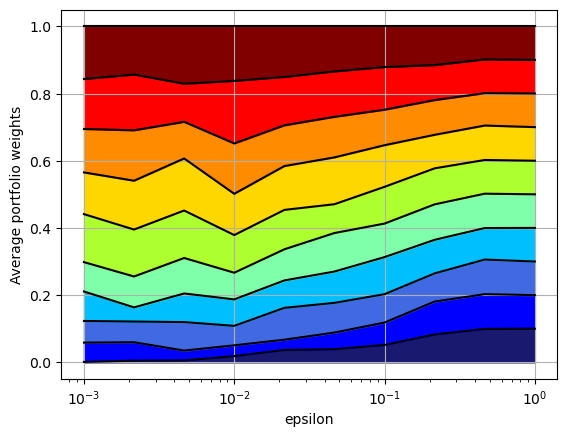

In [120]:
plt.figure(1)
plt.clf()

# colors=['Blue','RoyalBlue','DeepSkyBlue','Auqamarin','GreenYellow','Gold','DarkOrange','Red','Maroon']
colors=['#0000FF','#4169E1','#00BFFF','#7FFFAA','#ADFF2F','#FFD700','#FF8C00','#FF0000','#800000']

for i in range (m):
    plt.xscale('log')
    plt.plot(eps_scale, xi_print_list[i],color='black')
    if i == 0:
        # plt.fill_between(eps_scale, 0, xi_print_list[i], color='midnightblue',edgecolor='black')
        plt.fill_between(eps_scale, 0, xi_print_list[i], color='midnightblue')
    
    if i > 0:
        # plt.fill_between(eps_scale, xi_print_list[i-1], xi_print_list[i],color=colors[i-1],edgecolor='black')
        plt.fill_between(eps_scale, xi_print_list[i-1], xi_print_list[i],color=colors[i-1])

plt.xlabel('epsilon')
plt.ylabel('Average portfolio weights')

plt.grid()
plt.show()